In [1]:
import glob
import os, sys
import config_readwrite as crw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

# config

In [2]:
config, cfn = crw.read(os.path.join(os.getcwd(), "config.neuron.mpra.ini"))

section='lib2'
GABAS = glob.glob(config[section]["gaba"])
GLUTS = glob.glob(config[section]["glut"])

section="local_path"
PATH=config[section]["data_path"]
RE=config[section]["results_path"]

# functions

## open df

In [4]:
def listToDf(file_list, section):
    """
    return concatenated dataframe of files from file_list

    input 
        file_list (list) - list of file names as strings
        section (str) - variable should equal the string "lib2" or "lib1"

    method
        1. dictionary to collect dataframes
        2. iterate through files
        3. sample id str operations
        4. open file as pd dataframe
        5. formatting columns
            5.1. sample_id
            5.2. coordinates
            5.3. strand information. If control, no strand, mark 'ctrl'
            5.4 log2 activity
        6. add df to dictionary
    return 
        df of concatenated dictionary values
    """

    # 1
    dfs = {}

    # 2
    for f in file_list:

        # 3
        sample_id = (os.path.split(f)[1]).strip("-byInsert.tsv")  # get sample id label

        # 4
        df = pd.read_csv(f, sep='\t')  # open dataframe

        # 5 formatting columns

        # 5.1
        df["sample_id"] = sample_id  # add sample id
        
        
        if section=="lib2":
            df["celltype"] = sample_id.split("_")[1]
            df["name2"] = df["name"].apply(lambda x: x.split("_")[-1])
            df["coor"] = df["name2"].apply(lambda x: "chr"+":".join(((x.split("chr")[-1]).split("|")[0]).split(":")[:2]))
            df["coor"] = df["coor"].apply(lambda x: x.split("Backgroundseq2")[1] if "Background" in x else x)
            df["backgroundseq"] = df["name2"].apply(lambda x: True if "Background" in x else False)
        else:
            df["celltype"] = sample_id.split("_")[0]
            # 5.2 get coordinates
            
            df["coor"] = df["name"].apply(lambda x: ":".join(x.split(":")[:2]))

        # 5.3 get strand. For controls, no strand. return controls
        df["strand"] = None
        df.loc[df["name"].str.contains(":+"), "strand"] = "+"
        df.loc[df["name"].str.contains(":-"), "strand"] = "-"
        
        df["ctrl"] = "test"
        df.loc[df["name"].str.contains("Boaz"), "ctrl"] = None
        df.loc[df["name"].str.contains("72hr_top"), "ctrl"] = None
        df.loc[df["name"].str.contains("72hr_bottom"), "ctrl"] = None
        df.loc[df["name"].str.contains("shuf"), "ctrl"] = "shuf"

        #5.4
        df["log2ratio"] = np.log2(df["ratio"])
        # 6
        dfs[sample_id] = df  # add to dictionary

    return pd.concat(dfs.values())

## remove barcodes

In [5]:
def removeTags(df, min_tags):

    clean = df.loc[df["tags"] >= min_tags].copy()
    
    print(df.shape, clean.shape, 
          f"removed tags w/ <{min_tags} barcodes N=",
          df.shape[0]-clean.shape[0])
    return clean

## kde plot

In [6]:
def kdeplot(x, data, hue, title):
    fig, ax = plt.subplots(figsize=(4, 4))
    p = sns.kdeplot(x=x,
                data=data,
                hue=hue,
                common_norm=False,
                fill=True,
                alpha=0.3
                )
    ax.set(title=title, xlim=(-4,4))
    return p


def violinplot(x, y, data, hue, title):
    fig, ax = plt.subplots(figsize=(4, 4))
    p = sns.violinplot(x=x, y=y,
                   data=data,
                   hue=hue,
                   alpha=0.3
                   )

    return p

def compareCentering(x1, x2, clean_df, cell_type, out, treatment):
    fig, (ax1, ax2) =plt.subplots(figsize=(10,4), ncols=2)

    hue="sample_id"
    test_data = clean_df.loc[~clean_df["name"].str.contains("shuf")]
    shuf_data=clean_df.loc[clean_df["name"].str.contains("shuf")]

    sns.kdeplot(x=x1, data=shuf_data, 
                hue=hue,
                 ls="--", 
                 label="shuf-replicate",
                ax=ax1,
               common_norm=False
                )
    sns.kdeplot(x=x1,
                 data=test_data,
                 hue=hue,
                ax=ax1,
                fill = True, 
                label="test-replicate",
                 common_norm=False
                )

    ax1.legend()
    ax1.set(xlim=(-4,4), 
          title=f"Before {treatment}: {cell_type} test v. shuffle replicates")


    sns.kdeplot(x=x2, data=shuf_data, 
                hue=hue,
                 ls="--", 
                 label="shuf-replicate",

                ax=ax2,
               common_norm=False
                )
    sns.kdeplot(x=x2,
                 data=test_data,
                 hue=hue,
                ax=ax2,
                fill = True, 
                label="test-replicate",
                 common_norm=False
                )

    ax2.legend().remove()
    ax2.set(xlim=(-4,4), 
          title=f"After {treatment}: {cell_type} test v. shuffle replicates")
    plt.savefig(out, bbox_inches="tight")

## compute median activitye per trial

In [7]:
def ctrlMedians(df, activity_col):
    
    describe_activity=df.groupby(["ctrl", "sample_id"])[activity_col].describe().reset_index()
    describe_tags=df.groupby(["ctrl", "sample_id"])["tags"].describe().reset_index()
    medians = df.groupby(["ctrl", "sample_id"])[activity_col].median().reset_index()
    std = df.groupby(["ctrl", "sample_id"])[activity_col].std().reset_index()
    means = df.groupby(["ctrl", "sample_id"])[activity_col].mean().reset_index()
    
    return describe_activity, describe_tags, medians, std, means


## center activity of shuffled median per trial

In [8]:
def centerOnShufMed(df, mediandf, std, means):
    
    # get median of shuffles per trial
    shuf_med = mediandf.loc[mediandf["ctrl"]=="shuf", ["sample_id","log2ratio"]].copy()
    shuf_means = means.loc[means["ctrl"]=="shuf", ["sample_id","log2ratio"]].copy()
    shuf_std = std.loc[std["ctrl"]=="shuf", ["sample_id","log2ratio"]].copy()
    
    # rename median shuf col
    shuf_med = shuf_med.rename(columns={"log2ratio":"log2ratio_shufmedian"})
    shuf_means = shuf_means.rename(columns={"log2ratio":"log2ratio_shufmean"})
    shuf_std = shuf_std.rename(columns={"log2ratio":"log2ratio_shufstd"})
    
    # merge df w/ shuf_med
    df = pd.merge(df, shuf_med, how="left")
    df = pd.merge(df, shuf_means, how="left")
    df = pd.merge(df, shuf_std, how="left")
    
    # compute centered log2 ratio per median shuffle in trial
    df["log2ratio_centered"] = df["log2ratio"] - df["log2ratio_shufmedian"]
    df["z-score"] = stats.zscore(df["log2ratio"])
    df["z-score.shuf"] = (df["log2ratio"] - df["log2ratio_shufmean"])/df["log2ratio_shufstd"]
    
    return df

## compute mean activity across trials (after centering)

In [9]:
def meanRatio(df, value):
 
    # pivot data
    table = pd.pivot(df, 
         index=["name", "coor", "strand", "ctrl", "celltype"], 
         columns = "sample_id",
         values = value)
    
    # compute mean activity across the rows
    table[f'mean_{value}'] = table[list(table)].mean(axis=1)  

    return table.reset_index()

## label active as > 95% of shuffle

# main - normalize activity (log2 ratios) to shuffle median per trial

## params

In [10]:
RUNS = {"glut": GLUTS, 
       "gaba": GABAS}
MIN_TAGS = 10

In [11]:
df = pd.read_csv(GLUTS[0], sep='\t')
df.loc[df["name"].str.contains('shuf')]

,name,RNA,DNA,ratio,tags
180,shuffle_94_chr15:32646056-32646326,0.419648,0.463323,0.905736,166
255,shuffle_160_chr4:61500697-61500967,0.348357,0.403467,0.863410,95
340,Positive-shuffle35_chr12:44015386-44015655:+,0.751781,0.653603,1.150212,121
413,Negative-shuffle137_chr12:44592567-44592836:+,0.119123,0.233384,0.510419,26
554,Negative-shuffle116_chr2:171661323-171661592:+,0.129737,0.252373,0.514071,110
...,...,...,...,...,...
40664,shuffle_127_chr16:3501048-3501318,0.790558,0.930423,0.849677,5
40686,shuffle_15_chr1:27830775-27831045,0.313714,0.539375,0.581624,3
40718,shuffle_138_chr19:44891102-44891372,0.188228,0.101133,1.861197,2
41179,shuffle_63_chr16:71289621-71289891,0.302306,0.606797,0.498199,3


## run 

(124933, 11) (108091, 11) removed tags w/ <10 barcodes N= 16842
glut 

 before centering 

    ctrl     sample_id    count       50%
0  shuf  merge_glut_1    179.0 -0.242330
1  shuf  merge_glut_2    183.0 -0.210841
2  shuf  merge_glut_3    178.0 -0.245015
3  test  merge_glut_1  35537.0 -0.082769
4  test  merge_glut_2  35523.0 -0.079789
5  test  merge_glut_3  35260.0 -0.091417


 after centering 

    ctrl     sample_id    count       50%
0  shuf  merge_glut_1    179.0  0.000000
1  shuf  merge_glut_2    183.0  0.000000
2  shuf  merge_glut_3    178.0  0.000000
3  test  merge_glut_1  35537.0  0.159561
4  test  merge_glut_2  35523.0  0.131052
5  test  merge_glut_3  35260.0  0.153598
(125074, 11) (110168, 11) removed tags w/ <10 barcodes N= 14906
gaba 

 before centering 

    ctrl     sample_id    count       50%
0  shuf  merge_gaba_1    184.0 -0.283298
1  shuf  merge_gaba_2    184.0 -0.310470
2  shuf  merge_gaba_3    183.0 -0.294778
3  test  merge_gaba_1  35997.0 -0.055725
4  test  merge_

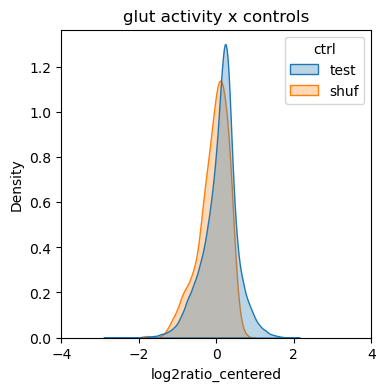

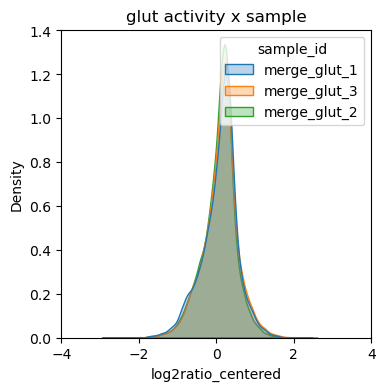

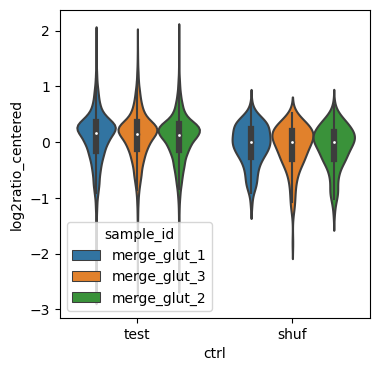

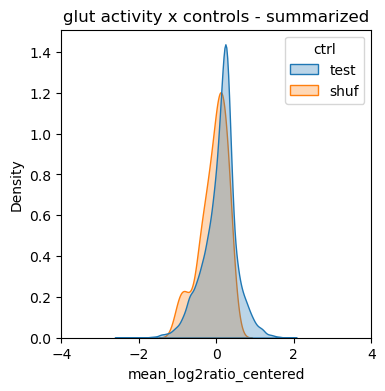

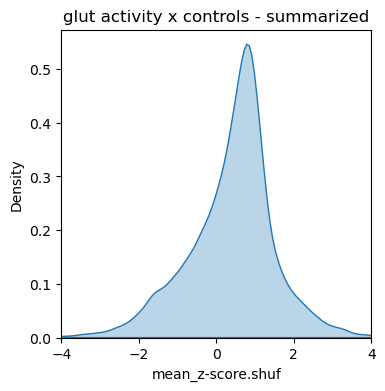

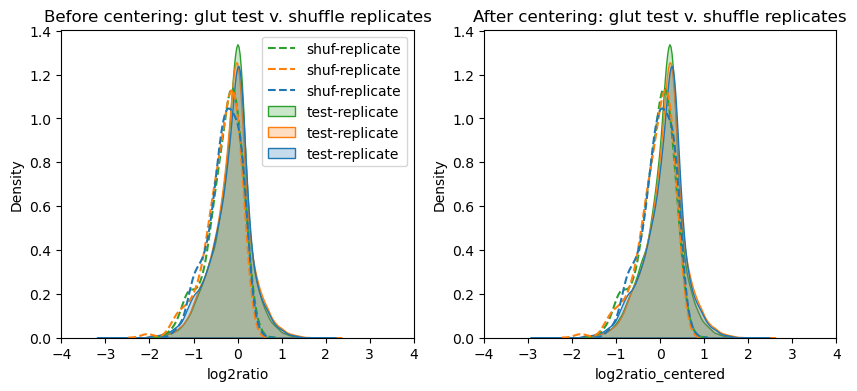

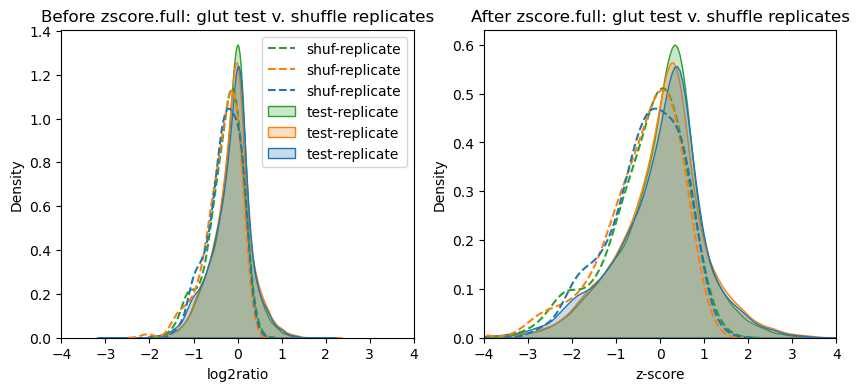

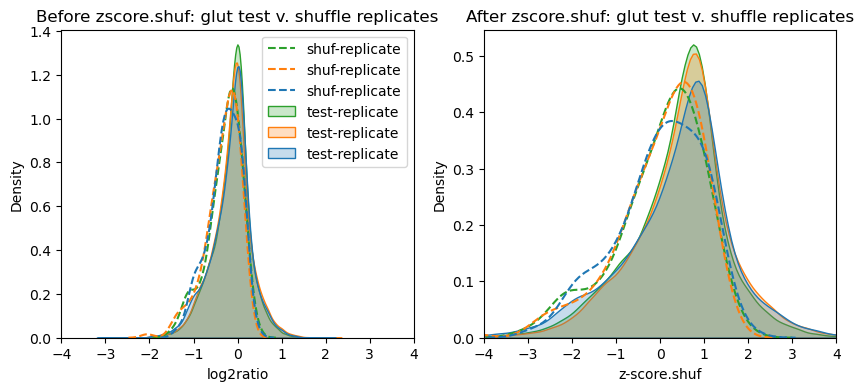

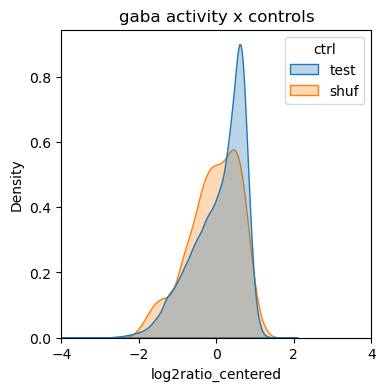

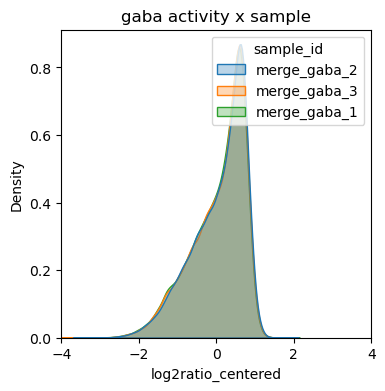

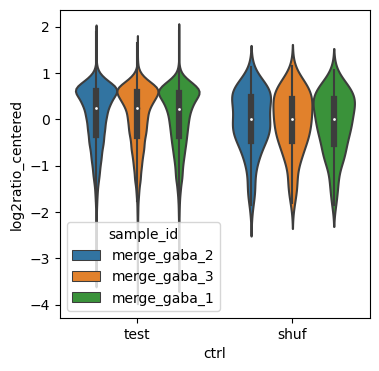

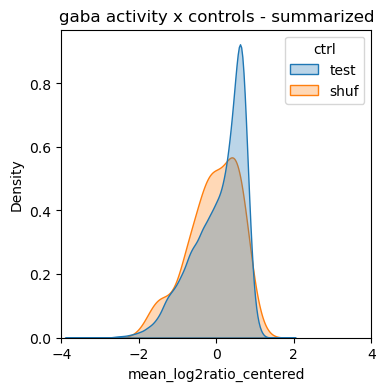

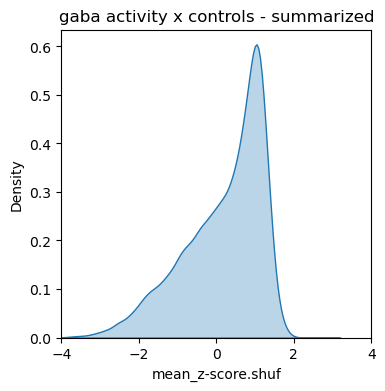

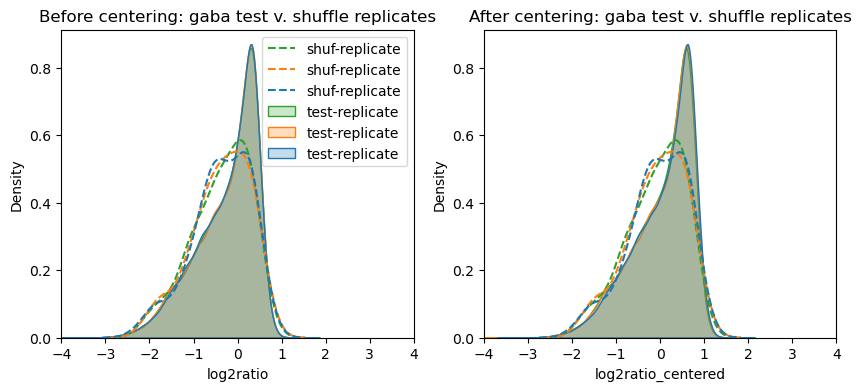

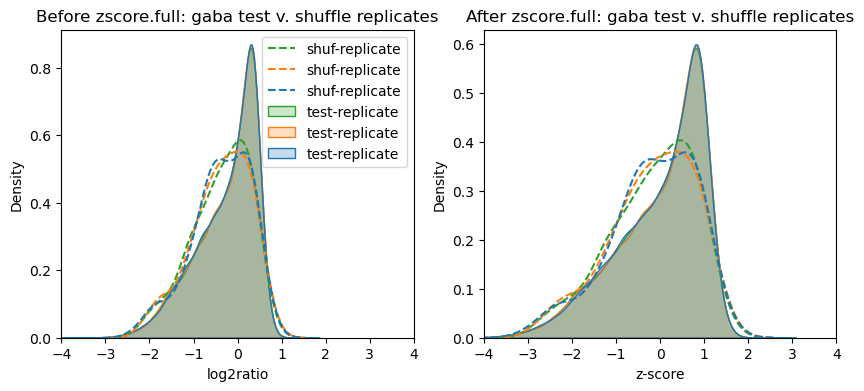

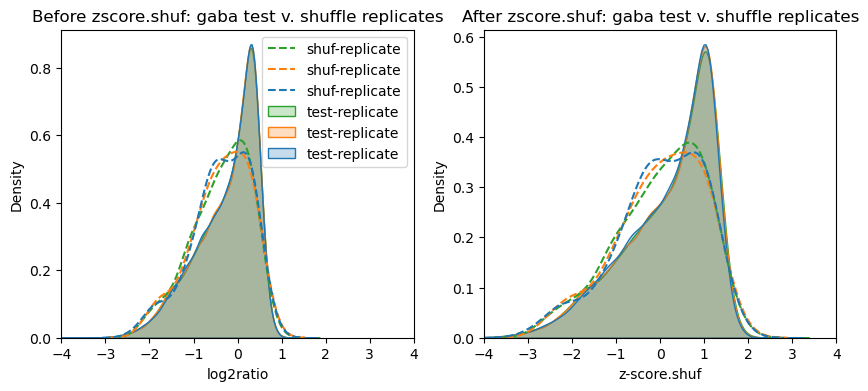

In [12]:
cleaned_reps,summ_act = {}, {}
PLOT = True
for cell_type, files in RUNS.items():

    df = listToDf(files, section)  # make df
    clean_df = removeTags(df, MIN_TAGS)  # clean df for min tags
    
    desc_act, desc_tag, medians, stds, means= ctrlMedians(
        clean_df, "log2ratio")  # compute medians
    
    # retrieve summary stats before
    print(cell_type,
          "\n\n before centering \n\n",
          desc_act[['ctrl',
                    'sample_id',
                    'count', "50%"]])  # describe activity across replicates
    # compute centered, z-score, and shuffled-z-score values
    clean_df = centerOnShufMed(clean_df, medians, stds, means)

    # retrieve summary stats after cnetering
    desc_act, desc_tag, medians, stds, means = ctrlMedians(
        clean_df, "log2ratio_centered")  # compute medians
   
    print("\n\n after centering \n\n",
          desc_act[['ctrl',
                    'sample_id',
                    'count', "50%"]])  # describe activity across replicates
    
    # add replicate data to dictionary
    cleaned_reps[cell_type] = clean_df
    
    ### summarize activity across replicates ###

    sum_df = meanRatio(clean_df, "log2ratio_centered")
    sum_df_ = meanRatio(clean_df, "z-score.shuf")
    sum_df = pd.merge(sum_df, sum_df_[["name", "mean_z-score.shuf"]])

    # add summarized data to dictionary
    summ_act[cell_type] = sum_df
    
    if PLOT is True:
        ### plot replicate data ###
        x = "log2ratio_centered"
        data = clean_df
        hue = "ctrl"
        title = f"{cell_type} activity x controls"
        kdeplot(x, data, hue, title)

        hue = "sample_id"
        title = f"{cell_type} activity x sample"
        kdeplot(x, data, hue, title)

        x = 'ctrl'
        y = "log2ratio_centered"
        hue = "sample_id"
        violinplot(x, y, data, hue, title)


         ### plot summarized data ###
        x = "mean_log2ratio_centered"
        data = sum_df
        hue = "ctrl"
        
        title = f"{cell_type} activity x controls - summarized"
        p = kdeplot(x, data, hue, title)
        out = os.path.join(RE, f"centering.summarized.{cell_type}.pdf")
        plt.savefig(out, bbox_inches="tight")
        
      
        # violin plot
        x = 'ctrl'
        y = "mean_log2ratio_centered"
        hue = None
        #violinplot(x, y, data, hue, title)

        ### plot summarized data z-score.shuf###
        
        x="mean_z-score.shuf"
        p = kdeplot(x, data, hue, title)
        out = os.path.join(RE, f"zscore.shuf.summarized.{cell_type}.pdf")
        plt.savefig(out, bbox_inches="tight")
        
        ### plot comparison of centering before and after ###
        out = os.path.join(RE, f"centering.comparison.{cell_type}.pdf")
        x1, x2 = "log2ratio", "log2ratio_centered"
        treatment = "centering"
        compareCentering(x1, x2, clean_df, cell_type, out, treatment)
        
        out = os.path.join(RE, f"zscore.comparison.{cell_type}.pdf")
        x1, x2 = "log2ratio", "z-score"
        treatment = "zscore.full"
        compareCentering(x1, x2, clean_df, cell_type, out, treatment)
        
        out = os.path.join(RE, f"zscore.shuf.comparison.{cell_type}.pdf")
        x1, x2 = "log2ratio", "z-score.shuf"
        treatment = "zscore.shuf"
        compareCentering(x1, x2, clean_df, cell_type, out, treatment)

# compare cell type specific activity

In [13]:
def labelActive(df, act_col, celltype):
    
    # compute median of the positive control activity values (mean across centered activity scores) 
    shuf_data= df.loc[df["ctrl"] == "shuf"]
    not_shuf = df.loc[df["ctrl"] != "shuf"]
    pos_thresh = shuf_data[act_col].quantile(0.95)
    print(act_col, "thresh of positive control", round(pos_thresh, 2))
    
    fig, ax=plt.subplots(figsize=(4,4))
    
    sns.kdeplot(not_shuf[act_col], label="test", fill=True, alpha=0.2)
    sns.kdeplot(shuf_data[act_col], label="shuf",fill=True, alpha=0.2, color='orange')
    ax.axvline(pos_thresh, ls="--", c='orange')
    ax.text(-4,0.3, f"95% shuf threshold = {round(pos_thresh, 2)}")  # annotate threshold
    ax.set(title=f"{celltype} active > 95% shuf active", 
          xlim=(-4,4),
          ylim =(0,0.6))
    
    out = os.path.join(RE, f"{celltype}.{act_col}.activity.threshold.pdf")
    
    plt.savefig(out, bbox_inches="tight")

    df["active"] = False
    df.loc[df[act_col]>=pos_thresh, "active"] = True
    
    p = pd.pivot(df, index="name", 
                  columns="celltype", 
                  values =act_col).reset_index()

    p = pd.merge(p, df[["name", "coor", 'strand', "active"]])

    # lib2 has some issues with cell type naming. Need to rename this column to be consisted w lib1
    if "merge" in list(p):
        p=p.rename(columns={"merge": celltype, "active": f"active.{celltype}"})
        p.loc[p[f"active.{celltype}"] == True, f"active.{celltype}"]=1
        p.loc[p[f"active.{celltype}"] == False, f"active.{celltype}"]=0
        print(p.groupby([f"active.{celltype}"])["name"].count())
    return p

In [14]:
def labelStrand(df_, celltype):
    df = df_.loc[df_["name"].str.contains("chr")]
    print(df.shape)
    df = pd.pivot(df, index="coor", columns="strand", 
                  values = ('active', celltype)).reset_index()
    df[f"n.active.strands.{celltype}"] = df["+"] + df["-"]
    
    return df

mean_z-score.shuf thresh of positive control 1.2
active.glut
0    29878
1     6687
Name: name, dtype: int64
mean_z-score.shuf thresh of positive control 1.26
active.gaba
0    33753
1     3265
Name: name, dtype: int64


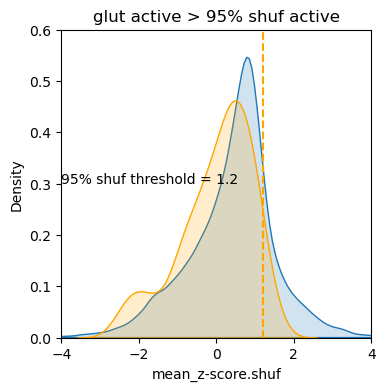

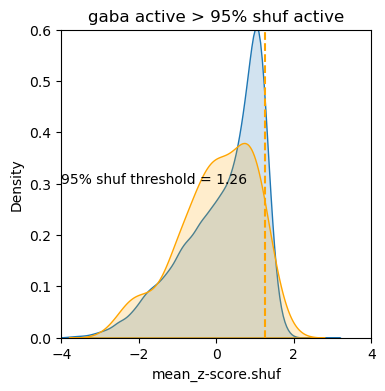

In [15]:
# make joint df
celltypes={"glut":None, "gaba":None}
ACTIVITY_COL = "mean_z-score.shuf"
strands = {}
for celltype in celltypes.keys():

    cell_df = summ_act[celltype] # get summary dataframe
    
    # label categorical activity
    cell_df=labelActive(cell_df, ACTIVITY_COL, celltype)
    
    # label strand-specific activity
    #strand_df=labelStrand(cell_df,celltype)
    
    # add to dictionaries
    celltypes[celltype] = cell_df
    #strands[celltype] = strand_df  # update the dataframe


In [16]:
cell_df.head()

,name,gaba,coor,strand,active.gaba
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.599713,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.657979,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.583023,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.114370,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.565814,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0


In [17]:
cell_df.groupby(["active.gaba"])["name"].count()

active.gaba
0    33753
1     3265
Name: name, dtype: int64

In [18]:
cell_df.groupby("coor").count().sort_values(by= cell_df.columns[0])

,name,gaba,strand,active.gaba
coor,,,,
chr20:44247965-44248235,1,1,1,1
chr3:32224256-32224526,1,1,1,1
chr3:32224236-32224506,1,1,1,1
chr3:32224216-32224486,1,1,1,1
chr3:32224196-32224466,1,1,1,1
...,...,...,...,...
"Backgroundseq172hr_top_98|Pos:105,135,165|Motiffamily",17,17,17,17
"Backgroundseq172hr_top_98|Pos:115,155|Motiffamily",19,19,19,19
"Backgroundseq172hr_top_98|Pos:105,125,145,165|Motiffamily",19,19,19,19


## joint strand 

In [ ]:
# collect strand-specific activity as set of coordinates that show ss activity in either gaba or glut
"""
ss_coor = set()

# ss columns to collect info from.
0 = both strands are inactive
1 = one strand is active in that cell type
2 = both strands are active in that cell type

ss_cols = ["n.active.strands.glut", "n.active.strands.gaba"]

# join the glut and the gaba
joint_strand = pd.merge(strands["glut"], strands["gaba"], how = "left", on="coor")

# add ss coordinates to the set
for col in ss_cols:
    print(col, joint_strand.loc[joint_strand[col]==1, "coor"].unique().shape)
    ss_coor.update(joint_strand.loc[joint_strand[col]==1, "coor"])
print("total strand-specific coordinates N=", len(ss_coor))
joint_strand.head()
"""

## joint activity

In [19]:

joint_activity = pd.merge(celltypes["glut"], celltypes["gaba"])

"""
# compute cell-specific activity column
0 = coor in both celltypes are inactive
1 = coor in one celltypes is active  ** cell type specific activity **
2 = coor in both celltypes are active
"""
joint_activity["n.active.cell"] = joint_activity['active.glut'] + joint_activity['active.gaba']

cell_coor = set(joint_activity.loc[joint_activity["n.active.cell"]==1, "coor"])

print("total cell-specific coordinates N=",len(cell_coor))
joint_activity.head()

total cell-specific coordinates N= 6818


,name,glut,coor,strand,active.glut,gaba,active.gaba,n.active.cell
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.544089,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0,-2.599713,0,0
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-0.244699,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0,-1.657979,0,0
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.628870,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0,-2.583023,0,0
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.748334,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0,-2.114370,0,0
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.377631,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0,-2.565814,0,0


## joint plot - glut v. gaba

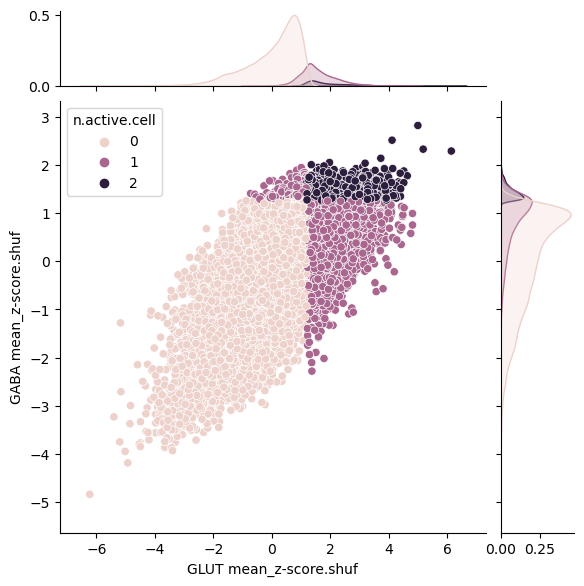

In [22]:
x = 'glut'
y = 'gaba'
hue ="n.active.cell"
data = joint_activity#.loc[joint_activity['strand'] != None]
j = sns.jointplot(x=x, y=y, data=data, marginal_ticks=True, hue=hue)

# rename axes
xlabel = f"GLUT {ACTIVITY_COL}"
ylabel = f"GABA {ACTIVITY_COL}"
j.set_axis_labels(xlabel, ylabel)


out = os.path.join(RE, f"glut.x.gaba.mean.l2.{ACTIVITY_COL}.pdf")
plt.savefig(out, bbox_inches="tight")

## pearson correlation between cell types

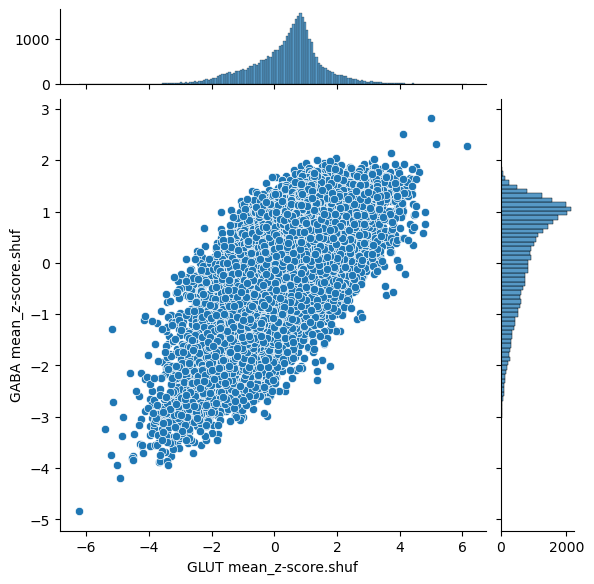

In [24]:
x = 'glut'
y = 'gaba'
hue ="n.active.cell"
data = joint_activity#.loc[joint_activity['strand'] != None]
j = sns.jointplot(x=x, y=y, data=data, marginal_ticks=True)

# rename axes
xlabel = f"GLUT {ACTIVITY_COL}"
ylabel = f"GABA {ACTIVITY_COL}"
j.set_axis_labels(xlabel, ylabel)


out = os.path.join(RE, f"glut.x.gaba.mean.l2.{ACTIVITY_COL}.no.hue.pdf")
plt.savefig(out, bbox_inches="tight")

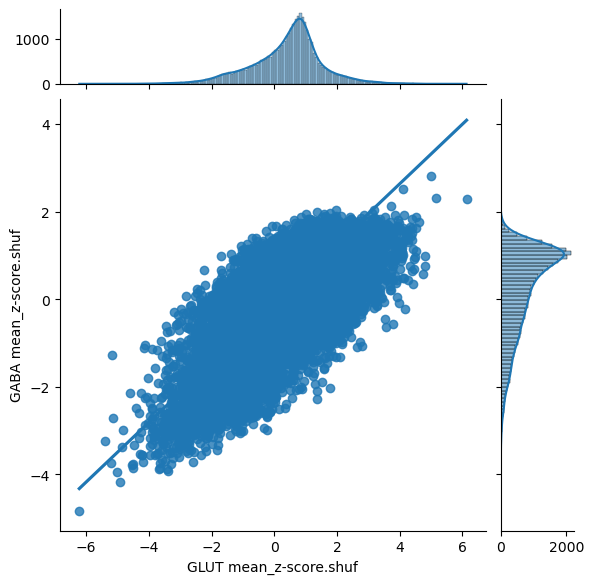

In [26]:
x = 'glut'
y = 'gaba'
hue ="n.active.cell"
data = joint_activity#.loc[joint_activity['strand'] != None]
j = sns.jointplot(x=x, y=y, data=data, kind="reg", marginal_ticks=True, )

# rename axes
xlabel = f"GLUT {ACTIVITY_COL}"
ylabel = f"GABA {ACTIVITY_COL}"
j.set_axis_labels(xlabel, ylabel)


out = os.path.join(RE, f"glut.x.gaba.mean.l2.{ACTIVITY_COL}.no.hue.lr.pdf")
plt.savefig(out, bbox_inches="tight")

In [27]:
stats.linregress(data[x], data[y])

LinregressResult(slope=0.6814593788982106, intercept=-0.08461294237235772, rvalue=0.7539757564803784, pvalue=0.0, stderr=0.0031058979382481175, intercept_stderr=0.0036857140962006235)

In [28]:
stats.pearsonr(data[x], data[y])

PearsonRResult(statistic=0.7539757564803788, pvalue=0.0)

## how many celltype-specific active?

In [29]:
joint_activity.loc[joint_activity['strand'] != None].groupby("n.active.cell")["name"].count()

n.active.cell
0    28163
1     6822
2     1559
Name: name, dtype: int64

# deltas

In [30]:
joint_activity.head()

,name,glut,coor,strand,active.glut,gaba,active.gaba,n.active.cell
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.544089,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0,-2.599713,0,0
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-0.244699,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0,-1.657979,0,0
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.628870,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0,-2.583023,0,0
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.748334,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0,-2.114370,0,0
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-1.377631,"Backgroundseq172hr_top_98|Pos1:115,Pos2",+,0,-2.565814,0,0


[Text(0.5, 1.0, 'delta mean_z-score.shuf')]

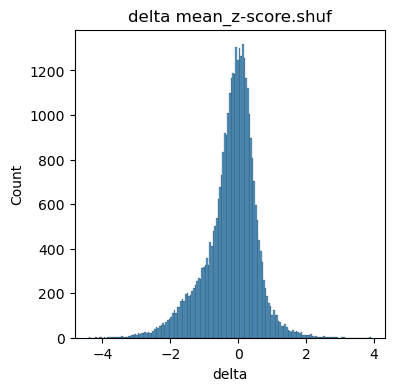

In [37]:
joint_activity['delta'] = joint_activity["gaba"] - joint_activity["glut"]

fig, ax = plt.subplots(figsize=(4,4))

sns.histplot(joint_activity['delta'])
ax.set(title=f'delta {ACTIVITY_COL}')

# cell type specific x strand specific 

 2x2 celltype specific coors enriched for strand-specific effects?
 
     - a = n coordinates with cell type AND strand-specific
     - b = n coordinates with cell type NOT strand-specific
     - c = n coordinates NOT cell type specific AND strand-specific
     - d = n coordinates NOT cell type NOT strand-specific
     
        ss +     ss-
    cs +   A.       B
    cs -   C.       D

In [ ]:
total_coor = set(joint_strand["coor"])  # get all coordinates
different_coor = {*ss_coor, *cell_coor}  # get set of different coordinates
a = len(cell_coor.intersection(ss_coor))
b = len(cell_coor.difference(ss_coor))
c = len(ss_coor.difference(cell_coor))
d = len(total_coor.difference(different_coor))

a,b,c,d

## Do FET

In [ ]:
from scipy.stats import fisher_exact

fisher_exact([[a,b],[c,d]])

In [ ]:
strand.loc[strand["name"].str.contains("chr")]